In [22]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.metrics import MeanAbsoluteError
from keras.utils import to_categorical
import seaborn as sns

In [2]:
df = pd.read_csv("data/training_set_rel3.tsv", sep='\t', encoding='ISO-8859-1');
df.dropna(axis=1,inplace=True)
df.drop(columns=['domain1_score','rater1_domain1','rater2_domain1'],inplace=True,axis=1)
df.head()
temp = pd.read_csv("Processed_data.csv")
temp.drop("Unnamed: 0",inplace=True,axis=1)

In [3]:
df['domain1_score']=temp['final_score']
df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",8
4,5,1,"Dear @LOCATION1, I know having computers has a...",6


In [4]:
df.iloc[3, 2]

'Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benifit our society. In some cases this is true but in most cases studdies show that computers can help people. While nothing beats talking in person computers can get really close such examples are webcams or e-mail. @PERCENT1 of students who get good grades refer to reliable websites for reasearch or to help find good books. Also online catalouges or advertisments help the economy of stores worldwide. @CAPS2 people were not allowed to use computers most of the modern would not exist. @PERSON1 said that the best form of modern communication is the computer because of the ability to write, talk, or write back for much cheaper! Almost every single event i go to is planed on a computer by communication such as e-mail "@CAPS2 a student ever needs homework because lam out sick or needs help studying for a test then contact their teacher through the best form of communication for them always e-mail. Even 

In [5]:
y = df['domain1_score']
df.drop('domain1_score',inplace=True,axis=1)
X=df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
train_list = X_train['essay'].tolist()
test_list = X_test['essay'].tolist()
train_sentences=[]
test_sentences=[]

stop_words = set(stopwords.words('english')) 
def sent2word(x):
    x=re.sub("[^A-Za-z]"," ",x)
    x.lower()
    filtered_sentence = [] 
    words=x.split()
    for w in words:
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def essay2word(essay):
    essay = essay.strip()
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw = tokenizer.tokenize(essay)
    final_words=[]
    for i in raw:
        if(len(i)>0):
            final_words.append(sent2word(i))
    return final_words

for i in train_list:
    train_sentences+=essay2word(i)

for i in test_list:
    test_sentences+=essay2word(i)

In [7]:
train_sentences[0]

['It',
 'first',
 'day',
 'high',
 'school',
 'gut',
 'full',
 'butterflies',
 'make',
 'want',
 'run',
 'bathrooms',
 'hide',
 'world']

In [8]:
def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.2, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64,recurrent_dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [9]:
#Training Word2Vec model
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

model = Word2Vec(train_sentences, 
                 workers=num_workers, 
                 vector_size=num_features, 
                 min_count = min_word_count, 
                 window = context, 
                 sample = downsampling)

model.init_sims(replace=True)
model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

c:\Users\yeshu\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  from ipykernel import kernelapp as app


In [10]:
def makeVec(words, model, num_features):
    vec = np.zeros((num_features,),dtype="float32")
    noOfWords = 0.
    index2word_set = set(model.wv.index_to_key)
    for i in words:
        if i in index2word_set:
            noOfWords += 1
            vec = np.add(vec,model.wv[i])        
    vec = np.divide(vec,noOfWords)
    return vec


def getVecs(essays, model, num_features):
    c=0
    essay_vecs = np.zeros((len(essays),num_features),dtype="float32")
    for i in essays:
        essay_vecs[c] = makeVec(i, model, num_features)
        c+=1
    return essay_vecs


clean_train=[]
for i in train_list:
    clean_train.append(sent2word(i))
training_vectors = getVecs(clean_train, model, num_features)

clean_test=[] 

for i in test_list:
    clean_test.append(sent2word(i))
testing_vectors = getVecs(clean_test, model, num_features)

c:\Users\yeshu\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [11]:
training_vectors = np.array(training_vectors)
testing_vectors = np.array(testing_vectors)

# Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
training_vectors = np.reshape(training_vectors, (training_vectors.shape[0], 1, training_vectors.shape[1]))
testing_vectors = np.reshape(testing_vectors, (testing_vectors.shape[0], 1, testing_vectors.shape[1]))
lstm_model = get_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 300)            721200    
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________


In [12]:
training_vectors.shape

(9083, 1, 300)

In [13]:
history = lstm_model.fit(training_vectors, y_train, batch_size=64, epochs=400)

Epoch 1/400
142/142 [==============================] - 4s 9ms/step - loss: 9.6090 - mae: 2.4026
Epoch 2/400
142/142 [==============================] - 1s 9ms/step - loss: 4.9197 - mae: 1.7456
Epoch 3/400
142/142 [==============================] - 1s 9ms/step - loss: 4.7306 - mae: 1.7050
Epoch 4/400
142/142 [==============================] - 1s 9ms/step - loss: 4.6308 - mae: 1.6843
Epoch 5/400
142/142 [==============================] - 1s 9ms/step - loss: 4.5413 - mae: 1.6693
Epoch 6/400
142/142 [==============================] - 1s 9ms/step - loss: 4.5347 - mae: 1.6712
Epoch 7/400
142/142 [==============================] - 1s 9ms/step - loss: 4.5556 - mae: 1.6668
Epoch 8/400
142/142 [==============================] - 1s 9ms/step - loss: 4.5013 - mae: 1.6577
Epoch 9/400
142/142 [==============================] - 1s 9ms/step - loss: 4.4427 - mae: 1.6477
Epoch 10/400
142/142 [==============================] - 1s 9ms/step - loss: 4.4785 - mae: 1.6495
Epoch 11/400
142/142 [=================

In [14]:
#lstm_model.save('optimized_lstm.h5')

In [15]:
y_pred = lstm_model.predict(testing_vectors)
y_pred = np.around(y_pred)
y_pred

122/122 [==============================] - 1s 2ms/step


array([[1.],
       [6.],
       [7.],
       ...,
       [8.],
       [8.],
       [9.]], dtype=float32)

In [16]:
y_pred[np.isnan(y_pred)] = 0

In [17]:
# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))

Kappa Score: 0.685360396584763


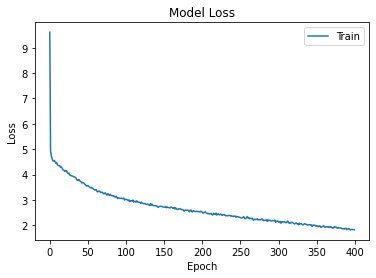

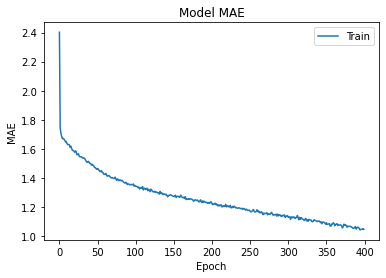

In [19]:
# Plot loss curve
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

# Plot accuracy curve (MAE in this case)
plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

Confusion Matrix:
[[  26  118]
 [  10 3739]]


<AxesSubplot:>

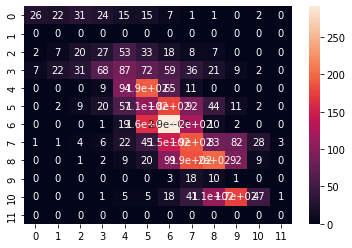

In [23]:
threshold = 0.5  # Define a threshold for binary classification
y_pred_binary = np.where(y_pred > threshold, 1, 0)
y_test_binary = np.where(y_test > threshold, 1, 0)
cm = confusion_matrix(y_test_binary, y_pred_binary)
print("Confusion Matrix:")
print(cm)
sns.heatmap(confusion_matrix(y_test.values, y_pred), annot=True)